In [70]:
'''
Code to test exponentially modified gaussian fit works

Christina Wang 04/04/2025

'''

import ROOT
import random
import math
import numpy as np
import os
import uproot
import sys
import subprocess

REPO_BASE_PATH = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
plot_path = f"{REPO_BASE_PATH}/plots/ADR/time_resolution_202503/"
os.makedirs(plot_path, exist_ok=True)

sys.path.append(REPO_BASE_PATH + "/lib")
from histo_utilities import *


In [71]:
### throw toys for EMG

def exp_modified_gaussian(mu, sigma, lambd, size=1):
    normal_samples = np.random.normal(mu, sigma, size)
    exponential_samples = np.random.exponential(1/lambd, size)
    return normal_samples + exponential_samples

hist = ROOT.TH1F("hist", "EMG Distribution", 200, -5, 15)

# Fit the histogram with a EMG function
mu = 0
sigma = 1
lambd = 0.5
size = 10000

emg_samples = exp_modified_gaussian(mu, sigma, lambd, size)
for i in range(size):
    hist.Fill(emg_samples[i])


In [72]:
### load actual data from SNSPDs to test the fit

files = {}
files_raw = {}
tree = {}
tree_raw = {}
# Open the input ROOT file
voltages = np.round([0.170],3)
biases = [4,1,2] #slot number of voltage source
pixels = [1,2,3] # pixel number in SNSPD
scope_ch = [2,3,4] # channel on scope

inputDirBase = "root://cmseos.fnal.gov///eos/uscms/store/user/christiw/SNSPD_data/ADR_time_resolution_202503/20250311_0p2K"

inputDir = f"{inputDirBase}/reco/v2/"
for ch_i, bias_ch in enumerate(biases): # loop over pixels
    name = f"B{bias_ch}_P{pixels[ch_i]}"
    for j, v in enumerate(voltages): # loop over voltages  
        bv_string = str(voltages[j]).replace(".","p")
        files[f'{name}_{bv_string}'] = inputDir+f'output_run{name}_BV{bv_string}.root'
for k, v in files.items():
    if not os.path.exists(v[v.find("/eos"):]): 
        print("FILE NOT FOUND", v)
        continue
    tree[k] = uproot.open(v)["pulse"]

print(tree.keys())

dict_keys(['B4_P1_0p17', 'B1_P2_0p17', 'B2_P3_0p17'])


In [121]:

time = {}
rise_time = {}
amplitude = {}
time_nofit = {}
time_50mV_nofit = {}
baseline_rms = {}
time_50mV = {}
s2n = {}
intercept = {}
slope = {}
for k, T in tree.items():
    amplitude[k] = T['amplitude'].array()
    rise_time[k] = T['rise_time'].array()
    intercept[k] = T['intercept'].array()
    slope[k] = T['slope'].array()
    
    time[k] = T['time'].array()
    time_nofit[k] = T['time_nofit'].array()
    time_50mV_nofit[k] = T['time_50mV_nofit'].array()
#     time_50mV[k] = T['time_50mV'].array()
    baseline_rms[k] = T['baseline_rms'].array()
    s2n[k] = amplitude[k]/baseline_rms[k]
    
    amp_threshold = 0.5 * np.array([np.mean(amplitude[k][:,0][amplitude[k][:,0]>-999]), np.mean(amplitude[k][:,1][amplitude[k][:,1]>-999])])
    time_50mV[k] = (amp_threshold/amplitude[k] - intercept[k]) / slope[k]
        
        
        
hist = create_TH1D((time_50mV[k][:,1]-time_50mV[k][:,0]), axis_title = ['SNSPD-laser time [ns]','Events'], binning = [300,50,60])
print(k)

B2_P3_0p17


Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


56.11788057060738 57.00540870865612
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      188.763
NDf                       =           23
Edm                       =   3.9967e-07
NCalls                    =          145
p0                        =      371.119   +/-   6.4204      
p1                        =      56.5391   +/-   0.00432841  
p2                        =     0.270596   +/-   0.00545131  


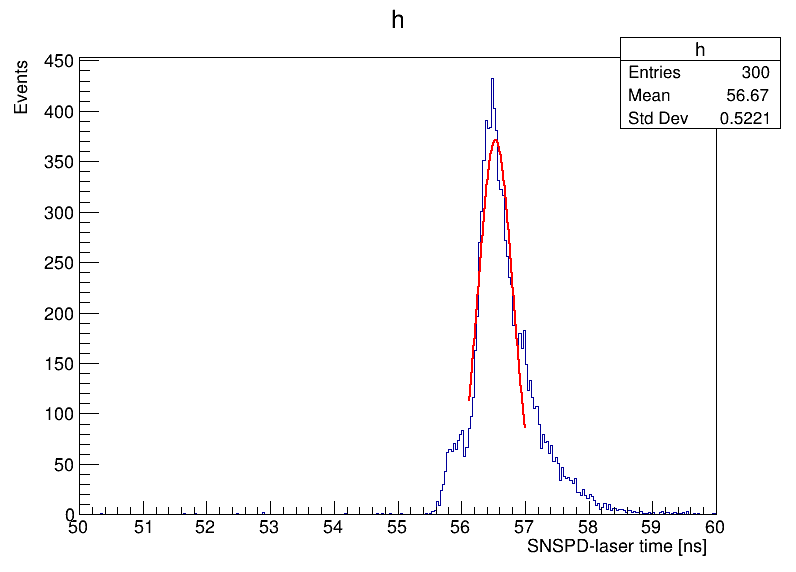

In [119]:
class myGaus:
    def __call__( self, t, par ):
        a = par[0] #amplitude
        c = par[1] #center
        s = par[2] #sigma
        x = t[0]   
        tmp = -1.*(x-c)*(x-c)/2. /(s*s)
        return a * math.exp( tmp )

    
class EMG:
    def __call__( self, t, par ):
    
        xx = t[0]
        amp = par[0]
        mu = par[1]    # Mean of the Gaussian
        sigma = par[2] # Standard deviation of the Gaussian
        lambd = par[3] # Rate parameter of the exponential

        if sigma <= 0 or lambd <= 0:
            return 0
        erfc_part = math.erfc((mu+lambd*sigma**2-xx)/(sigma*2**0.5))
        return amp*lambd/2*math.exp(lambd/2 *(2*mu + lambd*sigma**2-2*xx)) * erfc_part




# EMG = EMG()
# peak_position = hist.GetBinCenter(hist.GetMaximumBin())
# sigma = hist.GetRMS()
# nsig = 1
# # Define the fit range from -1 sigma to +1 sigma around the peak
# fit_range_min = peak_position - 0.7*sigma
# fit_range_max = peak_position + 3*sigma
# print(fit_range_min,fit_range_max)
    
# f = ROOT.TF1("gaus", EMG, 55,58, 4)
# f.SetParameter(0, 300) # scale
# f.SetParameter(1, 56) # scale
# f.SetParameter(2, 0.2) # mean
# f.SetParameter(3, 2) # standard deviation
# fit_result = hist.Fit(f, '','RS', fit_range_min,fit_range_max)


EMG = myGaus()
peak_position = hist.GetBinCenter(hist.GetMaximumBin())
sigma = hist.GetRMS()
nsig = 1
# Define the fit range from -1 sigma to +1 sigma around the peak
fit_range_min = peak_position - 0.7*sigma
fit_range_max = peak_position + 1*sigma
print(fit_range_min,fit_range_max)
    
f = ROOT.TF1("gaus", EMG, 55,58, 3)
f.SetParameter(0, 300) # scale
f.SetParameter(1, 56) # scale
f.SetParameter(2, 0.2) # mean
fit_result = hist.Fit(f, '','RS', fit_range_min,fit_range_max)

hist.Draw()

canvas.Draw()